In [1]:
#imports 

import numpy as np
from pathlib import Path
import pandas as pd
import pickle
import gc
import time

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# from scipy import signal

from demodTools import getTriggerWindows, demodSignal
from APOvsCSmain import IgmsCharac
from computeCSsolution import split_baselineSamples, flip_CSgrid
from CSwithSPGL1 import findSolution_spgBPDN, initThetaM


SPEED_OF_LIGHT = 299792458 # (m/s)



User variables

In [2]:
#path name and folder
# datapath = r"C:\Users\SimPot\Documents\projets\NIST\20220906StepScan"
datapath = r"20220906StepScan"
datafolder_name = 'cs02_50kpnts'

#file names
rawsig_filename ='cs02_50kpnts0001sig.txt'
rawtrig_filename ='cs02_50kpnts0001trig.txt'
    
#Sampling pattern file name and characteristics
filename_sampling_pattern = 'CSpattern_30fs_2_5kpnts.csv'
CS_nbSamples = 2500
APO_factor = 0.0

#igm characteristics filename
igmpool_file = "igmSCPool_July15_30fs.pickle"

#ADC Sample frequency
fS = 216e3 # Hz

#demodulation parameters
afterTriggerMaskPoints  = 12
beforeTriggerMaskPoints = 12
fIF                     = 50.0e3  # Intermediate frequency; Hz
# fIF                     = 50.025e3  # Intermediate frequency; Hz


# Solver options, spgl1
use_multiprocessing = True #Used for the theta matrix
nbThreads = 10 #Used for the theta matrix
opt_tol = 1e-4
spgl1verbosity = 1
iter_lim = 200


#plotting options
plotDemod = False
plotGridMapping = False
plotBaselineSplit = True
plotReconstructedIGM = True


#Export results
exportData = False
fileprefix = 'testExport'


load files

In [3]:
datafolder = Path(datapath,datafolder_name)

# load raws signals
sig = np.loadtxt(Path(datafolder,rawsig_filename))
trig = np.loadtxt(Path(datafolder,rawtrig_filename))

# check point
#make sure both traces are "align", match
if not len(sig) == len(trig):
    print('Warning, you should skip measurement')

#load sampling pattern    
df = pd.read_csv(Path(datapath,filename_sampling_pattern),header=None,engine='python')
x_opt_axis = df[0].to_numpy()

#load igm characteristics
with open(Path(datapath,igmpool_file),'rb') as f:
    igmpool_obj = pickle.load(f)
igmpool = igmpool_obj['igmpool']
cellUsedIgmpool = igmpool_obj['cell']
spc_parameters = igmpool_obj['spc_parameters']    


Demodulation section

Using a fix number of points per bin, 198.0 points


<IPython.core.display.Javascript object>


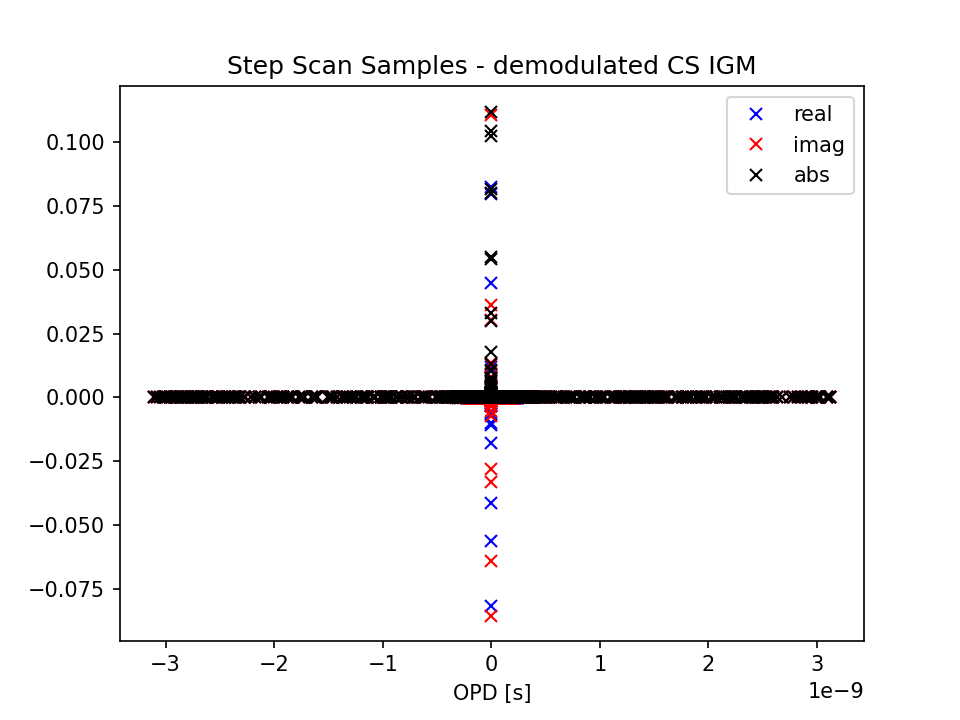

In [4]:
nbSamples = len(x_opt_axis)
startPoints, endPoints = getTriggerWindows(trig,beforeTriggerMaskPoints,afterTriggerMaskPoints, nbSamples )
baseBandIGM = demodSignal(sig, startPoints, endPoints, fS, fIF)

#check point
# is IGM maximum at 0.0 OPD?
assert x_opt_axis[np.argmax(np.abs(baseBandIGM))] == 0.0, 'IGM center at 0 OPD, check point failed'


# plot if true
if plotDemod:
    plt.figure()
    plt.plot(trig,label='trig')
    plt.plot(sig,label='sig')
    plt.legend()
    plt.xlabel('Point number')
    plt.title('Raw undemodulated IGM and trig signal')

    for ind_start,ind_stop in zip(startPoints,endPoints):
        plt.vlines(ind_start, 0.0, 1.0, colors='k', linestyles='dashed')
        plt.vlines(ind_stop, 0.0, 1.0, colors='k', linestyles='solid')


    ttt=[]
    for (startIndx, endIndx) in zip(startPoints, endPoints):
        ttt.append(endIndx-startIndx)
    
    plt.figure()
    plt.plot(ttt)
    plt.title('Number of points per bin - between 2 triggers')
    plt.xlabel('Bin number')
    plt.ylabel('Number of points per bin')
    
plt.figure()
plt.plot(x_opt_axis,np.real(baseBandIGM),'xb',label='real')
plt.plot(x_opt_axis,np.imag(baseBandIGM),'xr',label='imag')
plt.plot(x_opt_axis,np.abs(baseBandIGM),'xk',label='abs')
plt.title('Step Scan Samples - demodulated CS IGM')
plt.xlabel('OPD [s]')
plt.legend()
    


load and compute igm characteristics

In [5]:
ModelIGM  = IgmsCharac(igmpool_obj)
#generate all grid info
ModelIGM.setApodizationAndCSParams(APO_factor,CS_nbSamples)

print('IGM characteristics: ')
print('  APO factor is {}'.format(APO_factor))
print('  IGM length after APO is {} pts. Number of samples for CS is {} pts. The compressive factor is : {}'.format(
                ModelIGM.APO_igm_len, CS_nbSamples, ModelIGM.APO_igm_len/CS_nbSamples))


#generate full IGM axis grid
new_CS_x_opt_axis = [ModelIGM.APO_x_opt_axis[(np.abs(ModelIGM.APO_x_opt_axis - val)).argmin()] for val in x_opt_axis]

#check point -2-  Equidistant sampling grid
step_size = ModelIGM.APO_x_opt_axis[1] - ModelIGM.APO_x_opt_axis[0]
print('Step size is {} s'.format(step_size))
assert (new_CS_x_opt_axis-x_opt_axis < step_size / 100).all(), 'Equidistance OPD mapping, check point failed'


# plot if true
if plotGridMapping:
    fig, ax = plt.subplots( nrows=1, ncols=1 )
    ax.plot(new_CS_x_opt_axis-x_opt_axis)
    ax.set_ylabel('Error [s]')
    ax.set_xlabel('Sample number')
    ax.set_title('Step scan sampling jitter \n Samples OPD vs the closest point on the equidistant grid')    
        
        

IGM characteristics: 
  APO factor is 0.0
  IGM length after APO is 208332 pts. Number of samples for CS is 2500 pts. The compressive factor is : 83.3328
Step size is 3.0000192001078444e-14 s


Separate samples indexes in two: Baseline samples, samples without Baseline

<IPython.core.display.Javascript object>


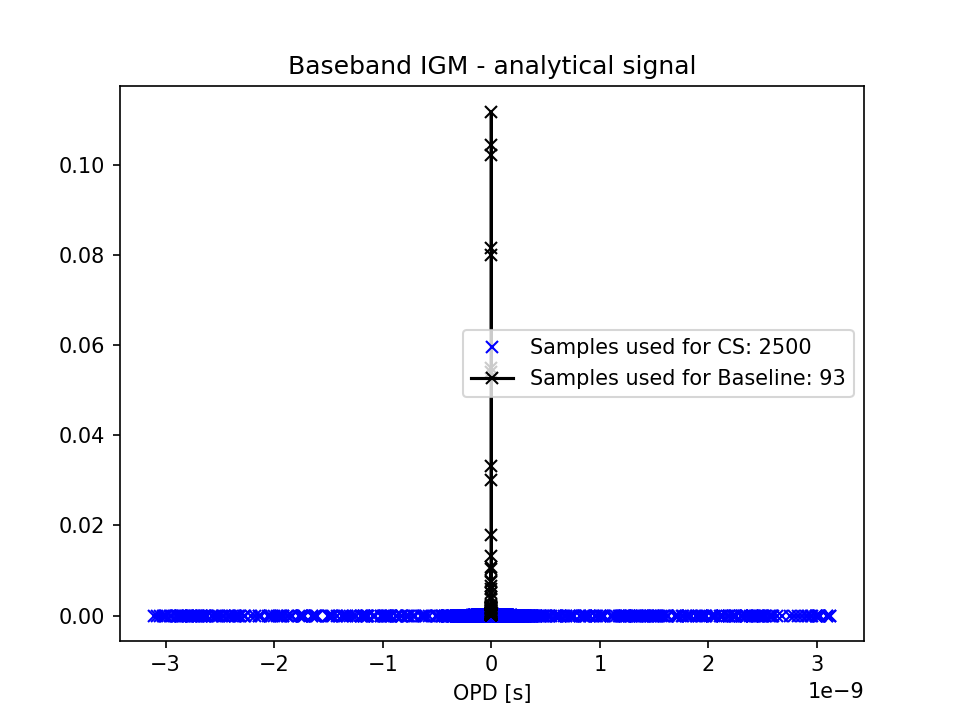

In [6]:
CS_x_opt_axis_noBL_idx, CS_x_opt_axis_BL_idx, samples_axis_noBL_idx, samples_BL_idx = split_baselineSamples(ModelIGM, x_opt_axis)
samples_x_opt_axis_noBL = ModelIGM.APO_x_opt_axis[CS_x_opt_axis_noBL_idx]
samples_x_opt_axis_BL = ModelIGM.APO_x_opt_axis[CS_x_opt_axis_BL_idx]
CS_igm_noBL = baseBandIGM[samples_axis_noBL_idx]
CS_igm_BL = baseBandIGM[samples_BL_idx]

if plotBaselineSplit:
    fig, ax = plt.subplots( nrows=1, ncols=1 )
    ax.plot(samples_x_opt_axis_noBL,np.abs(CS_igm_noBL),'bx' ,label='Samples used for CS: {}'.format(len(samples_axis_noBL_idx)))
    ax.plot(samples_x_opt_axis_BL,np.abs(CS_igm_BL),'-xk' ,label='Samples used for Baseline: {}'.format(len(CS_igm_BL)))
    ax.set_xlabel('OPD [s]')
    ax.set_title('Baseband IGM - analytical signal')
    ax.legend()


---- Find CS solution ----
-----------------------

In [7]:
#Variable selection
selected_indexes = CS_x_opt_axis_noBL_idx

#Evaluate the memory requirements for the theta matrix
ThetaSizeGB = 8*len(selected_indexes) /1000 * ModelIGM.APO_igm_len/1000 * 1e-3 *2 #[GB]
print('  Apodized igms have {} pts. With CS, the compressive_factor is {:.4}.'.format( 
                ModelIGM.APO_igm_len, ModelIGM.APO_igm_len/len(selected_indexes)))
print('  Theta matrix would take {} GB in memory'.format(ThetaSizeGB))



  Apodized igms have 208332 pts. With CS, the compressive_factor is 83.33.
  Theta matrix would take 8.33328 GB in memory


   The entire Theta matrix will stand in memory
   Creating the matrix... Done in 1.401e+01s!

SPGL1
No. rows              :     2500     
No. columns           :   208332

Initial tau           : 0.00e+00     
Two-norm of b         : 3.54e-03

Optimality tol        : 1.00e-04     
Target objective      : 5.00e-08

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      300



C:\Users\simon\OneDrive\SimonPotvin\NIST\Compressed sensing\APOvsCS_ArticleRelease\spgl1\spgl1.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  x *= s.astype(x.dtype)



EXIT -- Found a root

Products with A     :      84        Total time   (secs) :    37.3
Products with A^H   :      61        Project time (secs) :     1.8
Newton iterations   :       4        Mat-vec time (secs) :    34.2
Line search its     :      23        Subspace iterations :       0
    Found a solution in 60 iterations. sol type:1.
--- 51.870038986206055 seconds ---
moyenne : 51.870038986206055 s


<IPython.core.display.Javascript object>


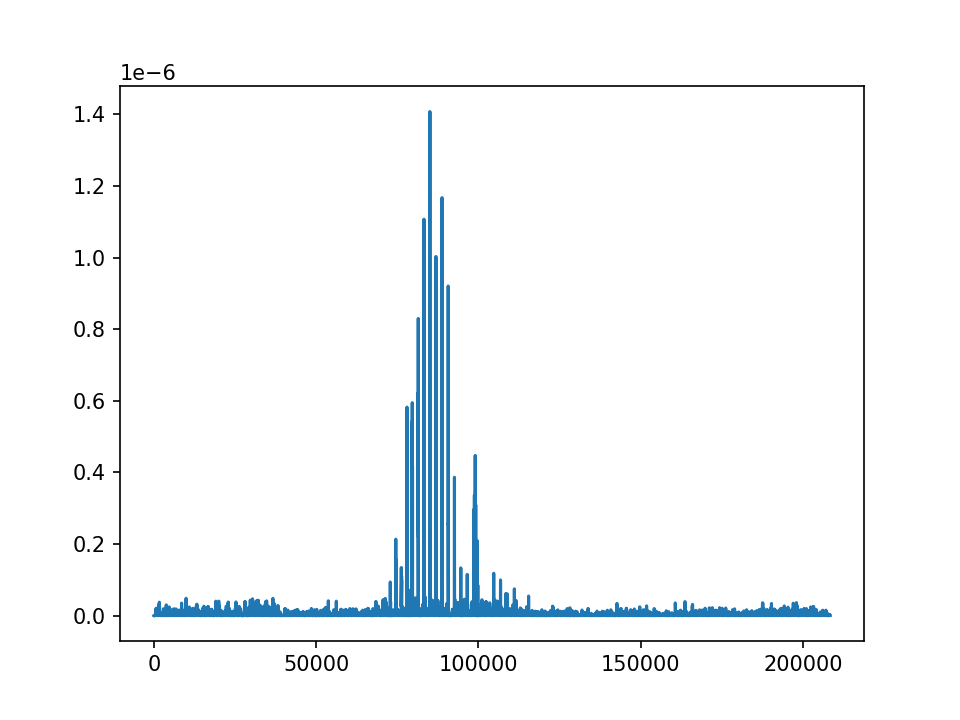

In [8]:
#Compute theta matrix and find a solution (sparse solution)
ori_vec_len = ModelIGM.APO_igm_len
samples = -1.0*CS_igm_noBL 
# Sign change, to have the absorption spectrum instead of the transmittance in the spectral domain. 
# A = 1-exp(-coeffs) ,   T = exp(-coeffs).  
# In the case of a perfectly flat transmittance (no baseline), the "1" is an unit impulse at OPD 0.0, which is removed by the mask.
# Then, there is a sign difference.


times_=[]
m_ord_limit = None
for i in range(1):
    start_time = time.time()
    theta = initThetaM(ori_vec_len, selected_indexes, toRAM=True, type='FFTcomplex',
                       use_multiprocessing = True, nbThreads = nbThreads)
    CS_solution_test = findSolution_spgBPDN(theta,samples,iter_lim=300,verbosity=spgl1verbosity,
                                       iscomplex=True, opt_tol=opt_tol, m_ord_limit = m_ord_limit)

    #delete and remove from memory the theta matrix
    del theta
    gc.collect()
    times_.append((time.time() - start_time))
    print("--- %s seconds ---" % (times_[i]))
    

print('moyenne : {} s'.format(np.mean(times_)))

plt.figure()
plt.plot(np.abs(CS_solution_test['s_est']))

<IPython.core.display.Javascript object>


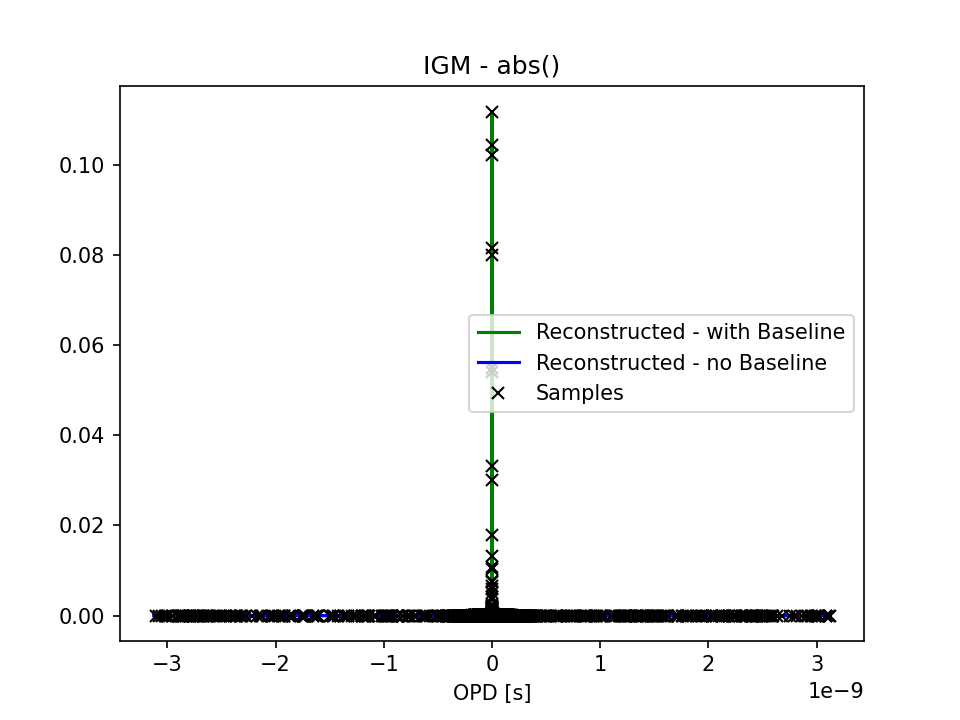

<IPython.core.display.Javascript object>


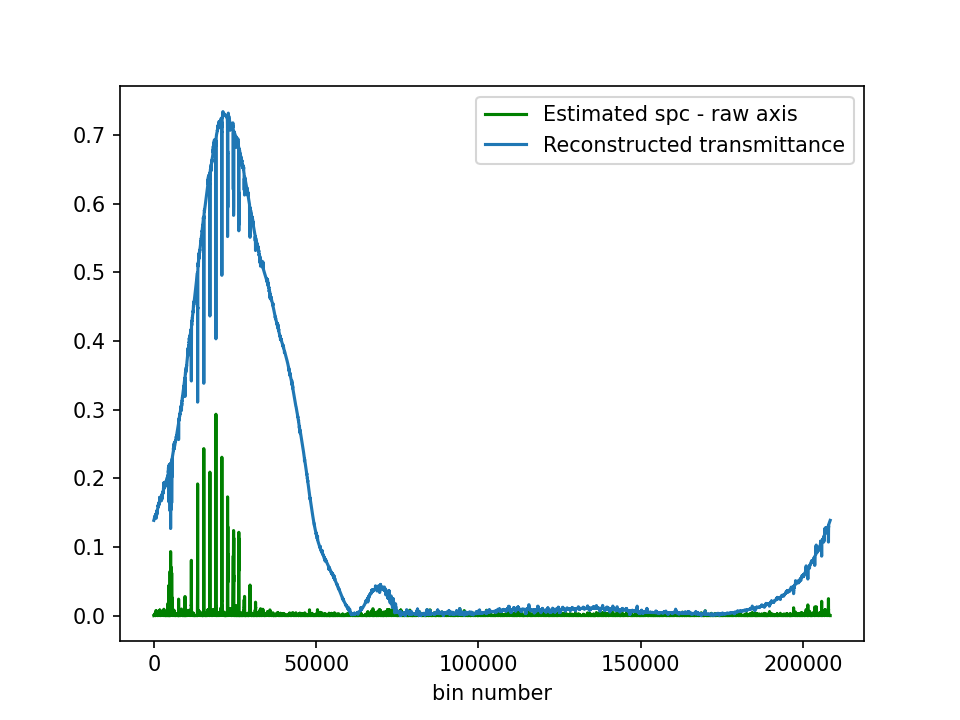

Number of spectral bins: 208332 
Model order is: 127996


In [9]:
# first fftshift for visualization and multiplication by the N (igm length)
# The N factor is always present and must come from a normalization step. either on theta or in the solution space...
s_est_tmp = np.fft.fftshift(CS_solution_test['s_est']) * ModelIGM.APO_igm_len

# the flipped grid problem origin is unknown, 
# My guest is that it is due to matrix manipulations within spgl1?
# it might be related to the way the fft is performed as the transform depends on the length of the IGM (even or odd number of points)
s_est = flip_CSgrid(s_est_tmp)

#Now that we have the right spectrum, we reconstruct the IGM
igm_est = np.fft.ifft(np.fft.ifftshift(s_est))

# Remove the center burst estimation and replace by the measured samples
igm_baseline_mask = ModelIGM.apodize(ModelIGM.baseline_mask)
tmp_vec = np.zeros(len(igm_est),dtype=np.complex_)
tmp_vec[CS_x_opt_axis_BL_idx] = baseBandIGM[samples_BL_idx]
new_igm_est = -1.0*(igm_est*igm_baseline_mask + -1.0*tmp_vec)
# Sign chang to return to the original form


if plotReconstructedIGM:
    fig, ax = plt.subplots( nrows=1, ncols=1 )
    ax.plot(ModelIGM.APO_x_opt_axis,np.abs(new_igm_est),'-g',label='Reconstructed - with Baseline')
    ax.plot(ModelIGM.APO_x_opt_axis,np.abs(-1.0*igm_est),'-b',label='Reconstructed - no Baseline')
    ax.plot(new_CS_x_opt_axis,np.abs(baseBandIGM),'xk',label='Samples')
    ax.set_title('IGM - abs()')
    ax.set_xlabel('OPD [s]')
    ax.legend()

    
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(np.abs(s_est),'-g',label='Estimated spc - raw axis')
transmit_spc_est = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(new_igm_est))))
ax.plot(transmit_spc_est,label='Reconstructed transmittance')
ax.set_xlabel('bin number')
ax.legend()


print('Number of spectral bins: {} '.format(len(s_est)))
print('Model order is: {}'.format(np.sum(s_est != 0.0)))



The next section is used to look at the estimated spectrum and try to find the right wavenumber axis.


In [10]:
#Export data

# if exportData:
#     np.savetxt(fileprefix + 'CS_x_opt_axis.txt', ModelIGM.APO_x_opt_axis, fmt='%.18e')
#     np.savetxt(fileprefix + 'CSigm.txt', new_igm_est, fmt='%.18e %.18e')
#     np.savetxt(fileprefix + 'CSraw.txt', CS_solution['s_est'] * ModelIGM.APO_igm_len, fmt='%.18e %.18e')



-----------------------------------------
-------- Fitting section ----------------
-----------------------------------------

In [11]:
from scipy.interpolate import RegularGridInterpolator, interp1d, interpn
from lmfit_modified import Model

from utils_fitting import bandwidth_select_td, weight_func_ps
from utils_fitting import generateLookuptbl


def estimateBaseLine_cplxIGM(igm, baseline_mask, clip_threshold=0.25):
    #Estimate baseline
    igm_centerburst = igm * (baseline_mask-1)

    baseline_est=np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(igm_centerburst))))
    estimated_max_envelope = np.max(baseline_est)
    baseline_est = baseline_est/estimated_max_envelope
    print('Baseline max estimation: {:.4}'.format(estimated_max_envelope))

    #TODO verify the envelop amplitude impact using this technique
    #TODO verify that the spectral SNR is good enough to clip at 25%

    # compute deconv filter
    G = 1/ (baseline_est)
    G = np.clip(G,0,1/clip_threshold)

    return G, estimated_max_envelope

def get_APOWinLookuptbl_cplxIGM(len_refIGM, wvn_axis, x_opt_axis ):
    ref_f_opt_axis = SPEED_OF_LIGHT * (wvn_axis*100)
    ref_x_opt_axis = np.arange(0,len_refIGM) * (1 / (len_refIGM *(ref_f_opt_axis[1]-ref_f_opt_axis[0])))
    ref_x_opt_axis = ref_x_opt_axis - ref_x_opt_axis[int(len_refIGM/2)]

    APO_win_s = (np.abs(x_opt_axis[0]) + np.abs(x_opt_axis[-1]))/2
    APO_win_lookuptbl = np.abs(ref_x_opt_axis) < APO_win_s
    
    return APO_win_lookuptbl, ref_x_opt_axis

def initFitModel_ILS(cell_lookuptbl):
    mod = Model(spc_lookup_ILS, independent_vars = ['xx','lookup_table_wvn_axis','lookup_table','ILS'],
                prefix=cell_lookuptbl['db_name'] + "_")
    mod.set_param_hint('path_cm',value=cell_lookuptbl["path_cm"],min=0)
    molefraction_value = np.random.default_rng().uniform(cell_lookuptbl['molfrac_range'][0],
                                                   cell_lookuptbl['molfrac_range'][1],1)[0]
    mod.set_param_hint('molefraction',value=molefraction_value, 
                       min=cell_lookuptbl['molfrac_range'][0], max=cell_lookuptbl['molfrac_range'][1])
    mod.set_param_hint('molefraction',value=molefraction_value, 
                       min=cell_lookuptbl['molfrac_range'][0], max=cell_lookuptbl['molfrac_range'][1])
    mod.set_param_hint('shift',value=0)
    pars = mod.make_params()
    pars[cell_lookuptbl['db_name'] + "_" + 'path_cm'].vary = False
    pars[cell_lookuptbl['db_name'] + "_" + 'shift'].vary = True
    return mod, pars

def spc_lookup_ILS(xx, lookup_table_wvn_axis, lookup_table, ILS, molefraction, path_cm, shift ):
    # Compute directly from Hitran. Time consuming.
    y0 = np.squeeze(lookup_table(np.array(([molefraction])))) * path_cm
    
    ## add instrument line shape
    # Be careful, add ILS on absorption spectrum related igm
    T_spc = np.exp(-1.0*y0) #compute Transmittance spectrum
    tmp_igm = np.real(np.fft.fftshift(np.fft.irfft(T_spc)))
    
    T_spc_ILS = np.clip(np.abs(np.fft.rfft(np.fft.ifftshift(ILS*tmp_igm))),0,None)
    y0_ILS = -np.log(T_spc_ILS)
    
    set_interp = interp1d(lookup_table_wvn_axis, y0_ILS, kind='quadratic')  #linear, quadratic, cubic
    new_y = set_interp(xx+shift)
    y_model_td = np.fft.irfft(new_y)

    return y_model_td



HAPI version: 1.1.1.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [12]:
#try to circumvent the axis problem
print('Characteristics of pickle file used by NIST')
print('  IGM length after APO is {} pts. Number of samples for CS is {} pts. The compressive factor is : {}'.format(ModelIGM.APO_igm_len,
                                                                                                                 CS_nbSamples,
                                                                                                                 ModelIGM.APO_igm_len/CS_nbSamples))

#Load igm characteristics
folderpath_igmpool = r".\20220906StepScan"
igmpool_file = "igmPoolSC01_CH4_NISTversion20220811_noiseless.pickle"

with open(Path(Path(folderpath_igmpool),igmpool_file),'rb') as f:
    igmpool_obj = pickle.load(f)   
igmpool = igmpool_obj['igmpool']
cellUsedIgmpool = igmpool_obj['cell']
spc_parameters = igmpool_obj['spc_parameters']

ModelIGM_patch  = IgmsCharac(igmpool_obj)
ModelIGM_patch.setApodizationAndCSParams(APO_factor,CS_nbSamples)

print('Characteristics of pickle file used to patche fitting problems')
print('  IGM length after APO is {} pts. Number of samples for CS is {} pts. The compressive factor is : {}'.format(ModelIGM_patch.APO_igm_len,
                                                                                                                 CS_nbSamples,
                                                                                                                 ModelIGM_patch.APO_igm_len/CS_nbSamples))
ModelIGM = ModelIGM_patch 



Characteristics of pickle file used by NIST
  IGM length after APO is 208332 pts. Number of samples for CS is 2500 pts. The compressive factor is : 83.3328
Characteristics of pickle file used to patche fitting problems
  IGM length after APO is 208332 pts. Number of samples for CS is 2500 pts. The compressive factor is : 83.3328


<IPython.core.display.Javascript object>


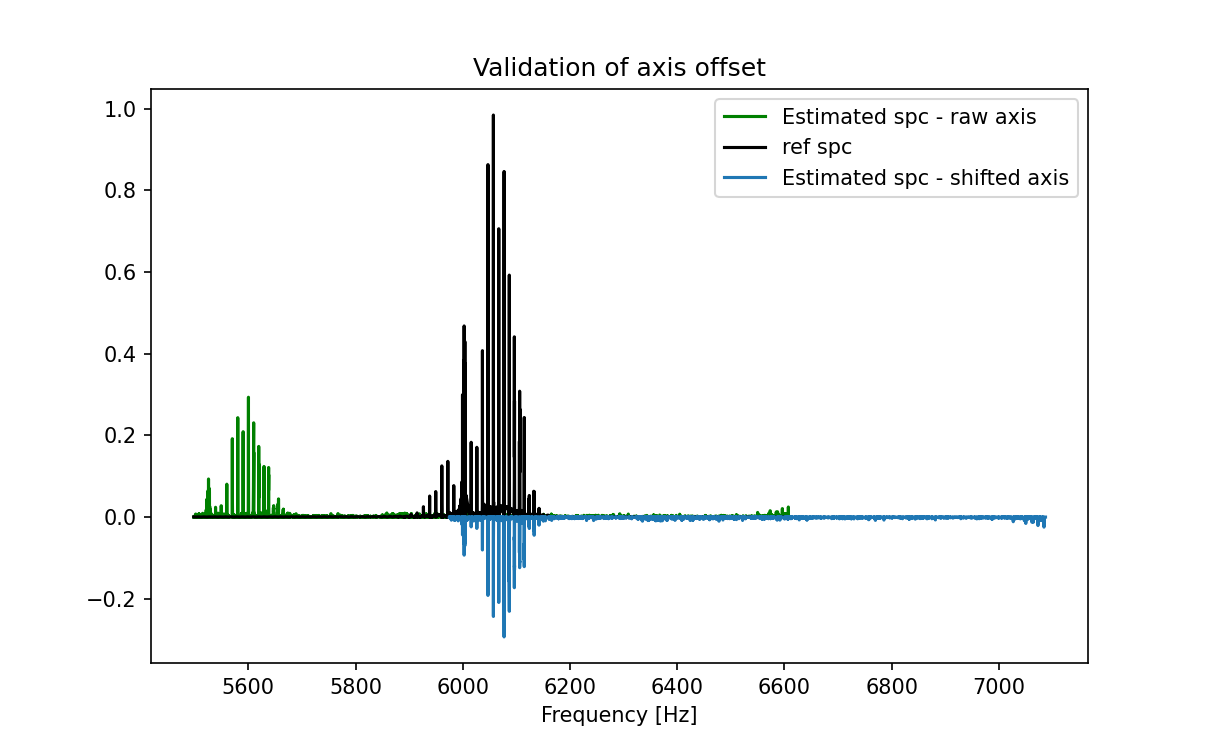

Use variable f_offset_toApply to shift the frequency axis of the raw axis. f_offset_toApply = -1.429296000007e+13


In [13]:


plt.figure()
plt.plot(ModelIGM.APO_wn_opt_axis,np.abs(s_est),'-g',label='Estimated spc - raw axis')

# Compare to a simulated IGM
CS_simulated_igm = -1*ModelIGM.apodize(igmpool[0])*ModelIGM.apodize(ModelIGM.baseline_mask)
CS_simulated_spc = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(CS_simulated_igm)))
plt.plot(ModelIGM.APO_wn_opt_axis,np.abs(CS_simulated_spc),'-k',label='ref spc')



#try to generate the right frequency axis
tmp_f_axis = np.fft.fftshift(np.fft.fftfreq(ModelIGM.APO_igm_len ,d=step_size))
corr_signal = np.correlate(np.abs(s_est), np.abs(CS_simulated_spc), "same")

f_offset_toApply = tmp_f_axis[np.argmax(corr_signal)]
CS_f_opt_axis = ModelIGM.APO_f_opt_axis - f_offset_toApply
CS_wn_axis= CS_f_opt_axis/(SPEED_OF_LIGHT*100)

plt.plot(CS_wn_axis,-np.abs(s_est),label='Estimated spc - shifted axis')
plt.xlabel('Frequency [Hz]')
plt.title('Validation of axis offset')
plt.legend()

print('Use variable f_offset_toApply to shift the frequency axis of the raw axis. f_offset_toApply = {:.12e}'.format(f_offset_toApply))

In [14]:
#Generate or load the lookup table use during the fit
#Also define the cell paramters for the lookup table

cell2use = cellUsedIgmpool
cell2use['path_cm'] = 75.0
path_cm = cell2use['path_cm']
cell2use['p_atm']= 0.8191463113742906 
cell2use['ti_kelvin']= 298.15 # 25 deg C

cell2use['molfrac_range'] = spc_parameters['molfrac_range']
cell2use['molfrac_range'] = [0.001, 0.05]  # because the result is most of the time underestimted

cell2use['band_fit'] = [5900, 6200] #cm-1
cell2use['nb_sampled_pts'] = 31
cell2use['spc_resolution'] = 0.0025 #cm-1
print(cell2use) 



# compute a new lookup table and save the result
import hapi
folder_name_hapi_lines = 'hapi/lines_local_db' # folder name where Hitran files are saved (.data and .header)
hapi.db_begin(folder_name_hapi_lines)

lookuptbl, wvn_axis = generateLookuptbl(cell2use)
with open(r".\20220906StepScan\lookuptable_NISTcell25d830mbar.pickle", 'wb') as f:
    pickle.dump({'lookuptbl':lookuptbl,'wvn_axis':wvn_axis }, f)

  

    
# # Load existing lookuptable
# with open(r"C:\Users\SimPot\Documents\projets\NIST\APOvsCS\lookuptable_NISTcell25d830mbar.pickle",'rb') as f:
#     lookuptbl_obj = pickle.load(f) 
# lookuptbl = lookuptbl_obj['lookuptbl']
# wvn_axis = lookuptbl_obj['wvn_axis']

{'db_name': 'CH4', 'mol_id': 6, 'iso': 1, 'molefraction': 0.22, 'ti_kelvin': 298.15, 'p_atm': 0.8191463113742906, 'path_cm': 75.0, 'molfrac_range': [0.001, 0.05], 'band_fit': [5900, 6200], 'nb_sampled_pts': 31, 'spc_resolution': 0.0025}
Using hapi/lines_local_db

CH4
                     Lines parsed: 48927
CO
                     Lines parsed: 190
CO2
                     Lines parsed: 10340
H2O
                     Lines parsed: 29294
HCN
                     Lines parsed: 23165
{'self': 0.001, 'air': 0.999}
{'self': 0.0026333333333333334, 'air': 0.9973666666666666}
{'self': 0.004266666666666667, 'air': 0.9957333333333334}
{'self': 0.0059, 'air': 0.9941}
{'self': 0.007533333333333334, 'air': 0.9924666666666667}
{'self': 0.009166666666666667, 'air': 0.9908333333333333}
{'self': 0.0108, 'air': 0.9892}
{'self': 0.012433333333333334, 'air': 0.9875666666666667}
{'self': 0.014066666666666668, 'air': 0.9859333333333333}
{'self': 0.015700000000000002, 'air': 0.9843}
{'self': 0.01733333333333

<IPython.core.display.Javascript object>


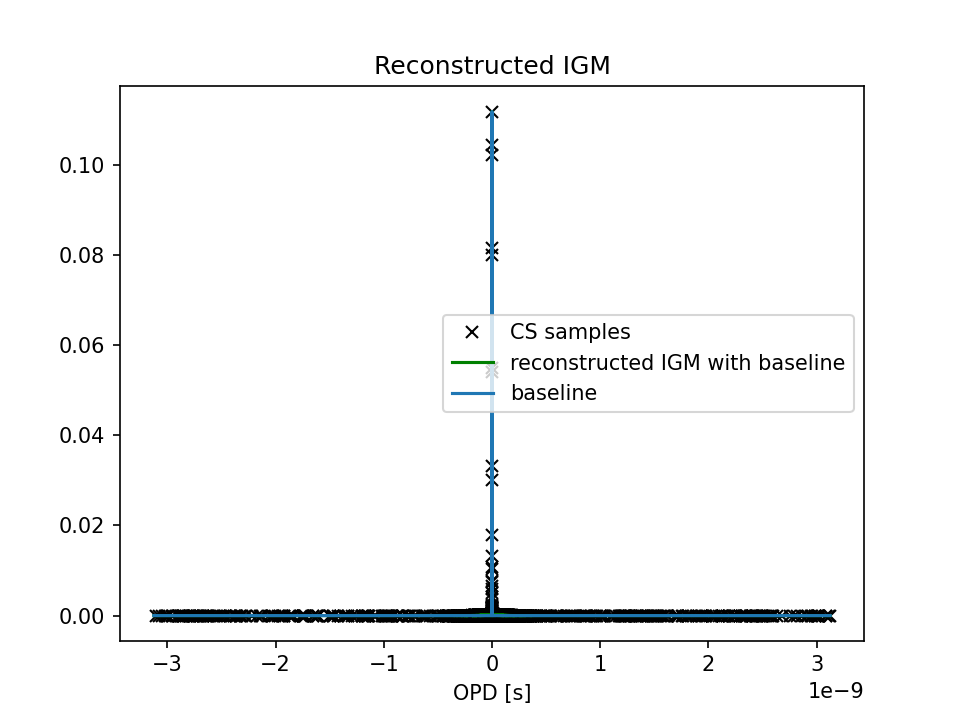

<IPython.core.display.Javascript object>


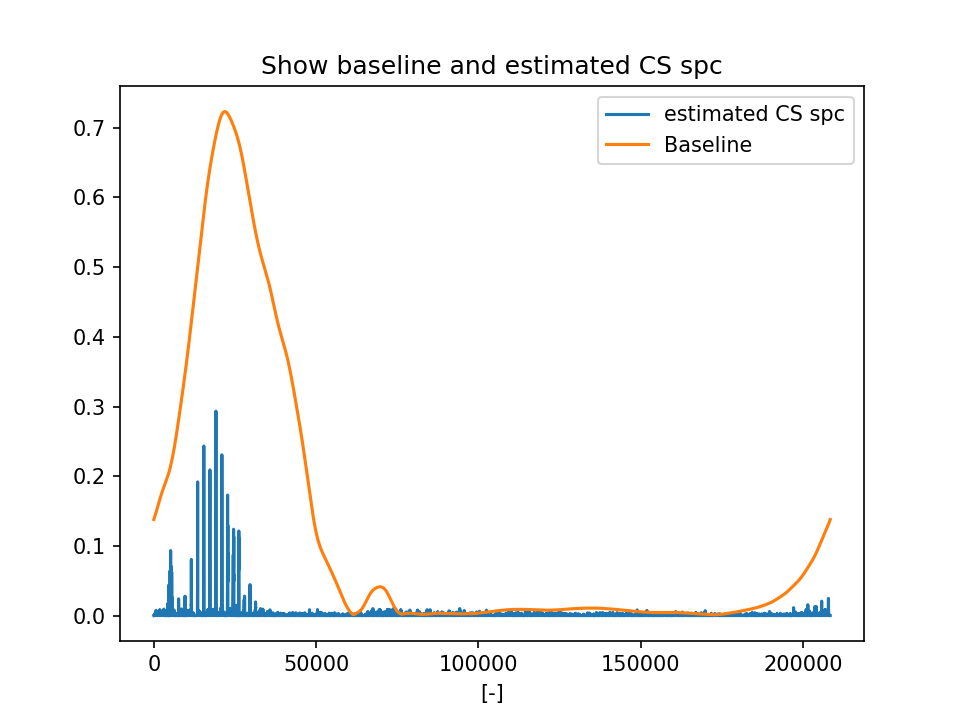

Baseline max estimation: 0.7231


<IPython.core.display.Javascript object>


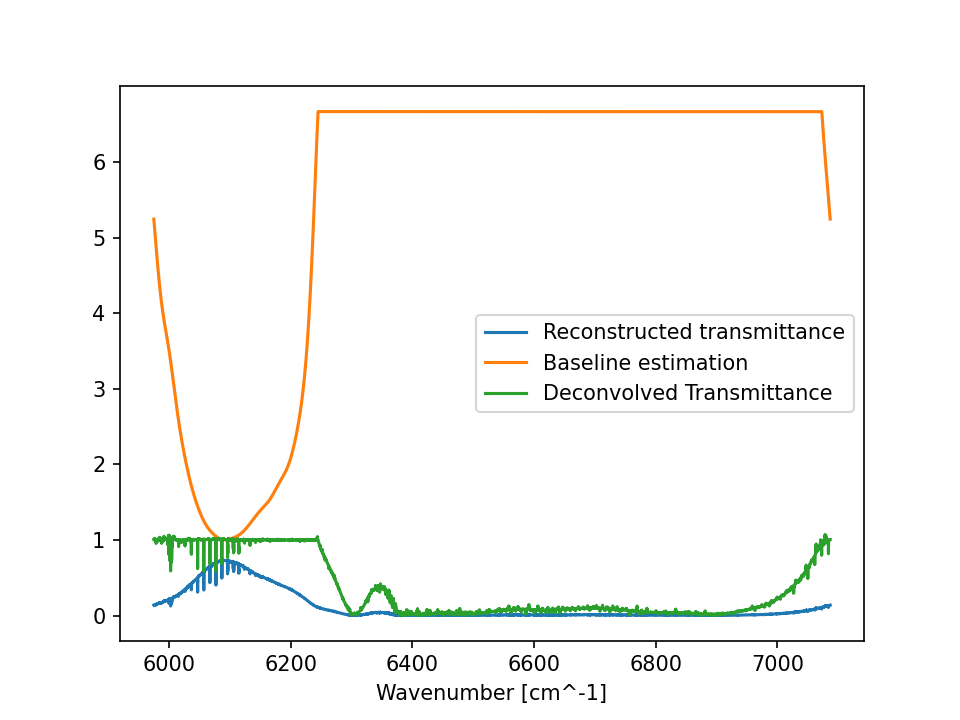

In [15]:
#Deconvolution of the baseline
# plot steps
clip_threshold = 0.15 # !!!! should be adjusted !!!! 


#Show resonctruted IGM
plt.figure()
plt.plot(new_CS_x_opt_axis,np.abs(baseBandIGM),'xk',label='CS samples')
plt.plot(ModelIGM.APO_x_opt_axis,np.abs(new_igm_est),'-g',label='reconstructed IGM with baseline')
plt.plot(ModelIGM.APO_x_opt_axis,np.abs(tmp_vec),label='baseline')
plt.title('Reconstructed IGM')
plt.xlabel('OPD [s]')
plt.legend()


#Show baseline
plt.figure()
plt.plot(np.abs(s_est),label='estimated CS spc')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(tmp_vec)))),label='Baseline')
plt.title('Show baseline and estimated CS spc')
plt.xlabel('[-]')
plt.legend()


#perform deconvolution
transmit_spc_est = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(new_igm_est))))
G, estimated_max_envelope = estimateBaseLine_cplxIGM(new_igm_est, igm_baseline_mask, clip_threshold=clip_threshold )
transmit_spc_est_deconv = np.clip(transmit_spc_est/estimated_max_envelope*G,0,None)

# #manage the igm at Nyquist
# transmit_spc_est = np.flipud(np.fft.fftshift(transmit_spc_est))
# G = np.flipud(np.fft.fftshift(G))
# transmit_spc_est_deconv =np.flipud(np.fft.fftshift(transmit_spc_est_deconv))

plt.figure()
plt.plot(CS_wn_axis,transmit_spc_est,label='Reconstructed transmittance')
plt.plot(CS_wn_axis,G,label='Baseline estimation')
plt.plot(CS_wn_axis,transmit_spc_est_deconv,label='Deconvolved Transmittance')
# plt.title('Reconstructed IGM')
plt.xlabel('Wavenumber [cm^-1]')
plt.legend()



In [16]:
# fit!!!

bl = ModelIGM.Optigm_BW * 1e12 * 2 
print('Bandwidth {} ps'.format(bl))
band_fit = [5996,6117]  


APO_wn_opt_axis  = CS_wn_axis
#select fitting region
# Verify that the band_fit is within the deconv region !!!!!!!!!!!!
ind_deconv_region = np.where(G < 1/clip_threshold)
deconv_band = [int(APO_wn_opt_axis[ind_deconv_region[0][0]]),int(APO_wn_opt_axis[ind_deconv_region[0][-1]])]
print('The deconvolution region is {} cm^-1.  '.format(deconv_band),end='')
print('The fitting region is {} cm^-1'.format(band_fit))
assert (band_fit[0] > deconv_band[0]) & (band_fit[1] < deconv_band[1])

st, en = bandwidth_select_td(APO_wn_opt_axis, band_fit, 11)
x_wvn = APO_wn_opt_axis[st:en]
weight = weight_func_ps(x_wvn, bl)

#prepare model
mod, pars = initFitModel_ILS(cell2use)
T_igm = np.fft.fftshift(np.fft.irfft(lookuptbl(np.array(([0.01])))[0]))
APO_win_lookuptbl,APO_win_x_axis = get_APOWinLookuptbl_cplxIGM(len(T_igm),wvn_axis, ModelIGM.APO_x_opt_axis)

y_td = np.fft.irfft(-np.log(transmit_spc_est_deconv[st:en]))
Fit = mod.fit(y_td, params = pars, xx = x_wvn, lookup_table_wvn_axis =wvn_axis, lookup_table = lookuptbl,
                ILS = APO_win_lookuptbl, weights = weight, fit_kws ={'ftol':1.0e-14, 'xtol':1.0e-14})

# print('Mole Fraction is: ',molefraction)
print('Fitting result is: ',float(Fit.best_values[cell2use['db_name'] + "_molefraction"]))

Bandwidth 6.481125386230241 ps
The deconvolution region is [5974, 7086] cm^-1.  The fitting region is [5996, 6117] cm^-1
Variables:  xx
Variables:  lookup_table_wvn_axis
Variables:  lookup_table
Variables:  ILS
Fitting result is:  0.01703458849173543
